> **WARNING** It is more than recommended to work on a copy of that file (_i.e._ not IN the cloned git repository) otherwise next time you update the repo with `git pull` you'll face a `merging` issue and these are tricky to manage

# Tracking Single Provenance

In this notebook, we will use the basic `trackscape` module, aka without the python helper, to run fluvial landscapes going through an uplifting range and a foreland basin, like the previous example, but in this one we want to track the proportion of material coming from a specific source area into the sediment flux and the stratigraphy.

## Setting up the Parameters

We will set the basic parameters first, see previous notebook for more details. Note that we elongate the model in the Y direction to make a nicely outlined foreland. We also set the left and right BC to periodic in order to have an infinite foreland.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dagger as dag



%matplotlib widget
# Most of the parameters are already explained in previous examples
ny,nx = 512,256
dy,dx = 200,200
dt = 500
Kr = 1e-5
Ks = 2e-5
dep = 4
rshp = (ny,nx)

# Initialising an empty model in the variable ts
ts = dag.trackscape()
# Initialising the topography and its dimensions
ts.init_random(dag.NOISE.WHITE, nx, ny,dx,dy,"periodic_EW")

# FUnctions to set parameters as global homogeneous values (if not initialised, there is a default value)
ts.set_single_Kr(Kr)
ts.set_single_Ks(Ks)
ts.set_single_depcoeff(dep)

# Deactivate hilllsopes processes
ts.hillslopes_off()

### Setting the uplift field

As mentioned, we will set a simple uplift field to have a range and a foreland. We will proceed in multiple steps:

- Create a 2D array of model size to 0 (shape is ny,nx for n rows and n columns)
- This time, we set the range in the northern part of the domain in the y direction to 1 mm/yrs of uplift
- We also set the Northern boundary to a fixed elevation of 300m -> this will simulate an asynchronous half-mountain range and allow us to only focus on a single side of the range
- visualise
- Linearise (the `c++` model only takes 1D arrays, this will be simplified with a `python` package on the top)

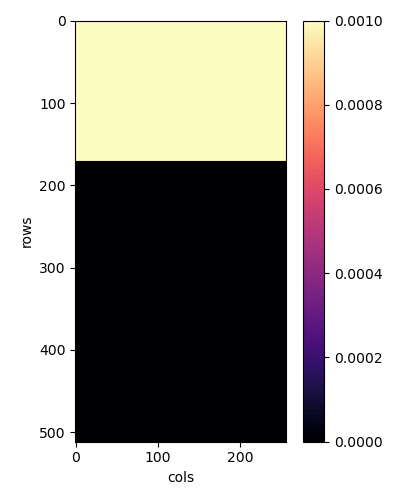

In [2]:
# initialising the array
Ufield = np.zeros(rshp)

# Getting the coordinates of the third of the domain:
third = round(ny/3)

# Setting to 1 mm/yrs
Ufield[:third,:] = 1e-3

# Setting up the Northern boundary
ts.rise_boundary_by("N", 300)
ts.fill_up() # not mandatory but cleans up numerical artifacts for the first few time steps

fig,ax = plt.subplots(figsize = (4,5))
cb = ax.imshow(Ufield, cmap = "magma")
ax.set_xlabel("cols")
ax.set_ylabel("rows")
plt.colorbar(cb)
plt.tight_layout()

# Linearising
Ufield = Ufield.ravel()

## Setting up provenance parameters

This is the important new bits to consider here. We are defining a source area producing a certain concentration of material (between 0 and 1). We then activate the module within the model and feed that original concentration. 

Note that here we keep things simple and only define a rectangle of source area, but the latter could be redefined and refeed at every timestep (for example as a feedback of a 3D lithologic block).

In [3]:
# initialising the array
sourceField = np.zeros(rshp)

# We'll place a rectangle of source area at an arbitrary place
sourceField[100:130,100:140] = 0.8

# Seeting up a spatial resolution for the stratigraphy
nz = 1

# Now let's enable the module with the concentration:
ts.init_TSP_module(nz, sourceField)


## Running the model

Let's run the model. You can set ndt to 0 to skip that part, or even jump to the next section, or finally use the stop button at the top of the script to stop the model execution without stopping the all notebook.

This first cell generates the figure, we will plot the topography as well as the sediment height. We are also getting the hillshaded relief, as it does make things nicer and show a reference point for the sediment field.

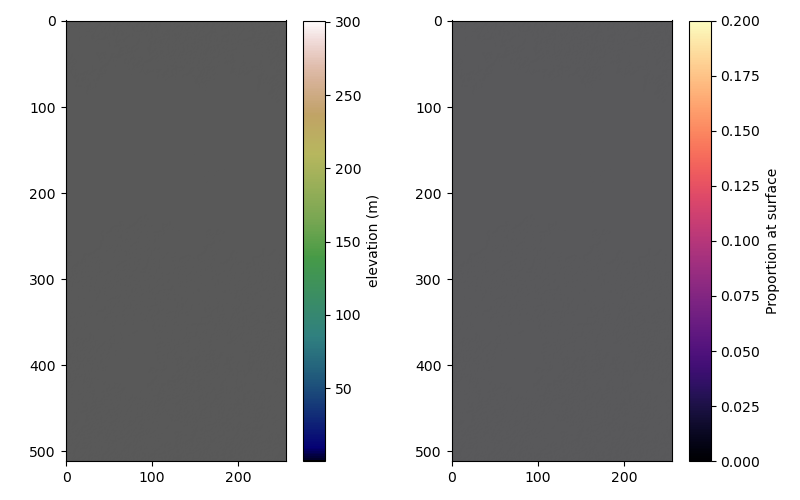

In [4]:
fig,ax = plt.subplots(1,2, figsize = (8,5))

topo = ts.get_topo().reshape(rshp)
hillshade = ts.connector.get_HS(ts.get_topo()).reshape(rshp)
topoplot = ax[0].imshow(topo, cmap = "gist_earth")
hsplot0 = ax[0].imshow(hillshade, cmap = "gray", alpha = 0.5, vmin = 0, vmax = 1)
prop_surface = ax[1].imshow(np.zeros_like(topo), cmap = "magma", vmin = 0, vmax = 0.2)
hsplot1 = ax[1].imshow(hillshade, cmap = "gray", alpha = 0.5, vmin = 0, vmax = 1)
plt.colorbar(topoplot, label = "elevation (m)")
plt.colorbar(prop_surface, label = "Proportion at surface")
plt.tight_layout()

**Let's now run the model `ndt` times, and update the figure every `nupdate` timesteps** (updating the figure too often can be costly).

You can also set the cmaps value to a constant value with the `set_clim` functions.

> **Note** the figure is updated in place, just above. If you deactivated the widget, it won't work

In [7]:
ndt = 10000
nupdate = 100

# Main loop
for i in range(ndt):
    # Calling the run function for single flow
    ts.run_SFD(dt)
    # Calling hte block uplift funtion)
    ts.external_uplift(Ufield,dt, False)
    
    # If nupdate^th timestep: I update the fig
    if(i%nupdate == 0):
        ## printing the timestep
        print("                   ",end = "\r")
        print("Timestep",i,end = "\r")
        
        # Simulating "Fading source through time"
        sourceField *= 0.9
        ts.update_TSP_source(sourceField)
        
        #GEtting the topography
        topo = ts.get_topo().reshape(rshp)
        # Calculating hillshade
        hillshade = ts.connector.get_HS(ts.get_topo()).reshape(rshp)
        # Setting the new data
        topoplot.set_data(topo)
        # Setting the new colorbar limits
        topoplot.set_clim(topo.min(), topo.max())
        # Updating hillshades
        hsplot0.set_data(hillshade)
        hsplot1.set_data(hillshade)
        # Accessing AND updating sed height
        tprop = ts.get_TSP_surface_concentrations().reshape(rshp)
        prop_surface.set_data(tprop)
        
        # Apply the update
        fig.canvas.draw()
        
        
        
        

KeyboardInterrupt: 

## Checking the stratigraphy

Now this only provides informations about the surface proportion. It is also possible to query stratigraphic information.

I hope to get more options in the futur, but so far you can get cross-sections of the proportion in the X and Y direction:

> **WARNING** Still work in progress: the blocky aspect near the surface is due to the depth discretization: at the moment a box start receiving sediments it is displayed as full and "jumps" a meter higher. I'll sort that in a future update but the syntax will have to change to some extent

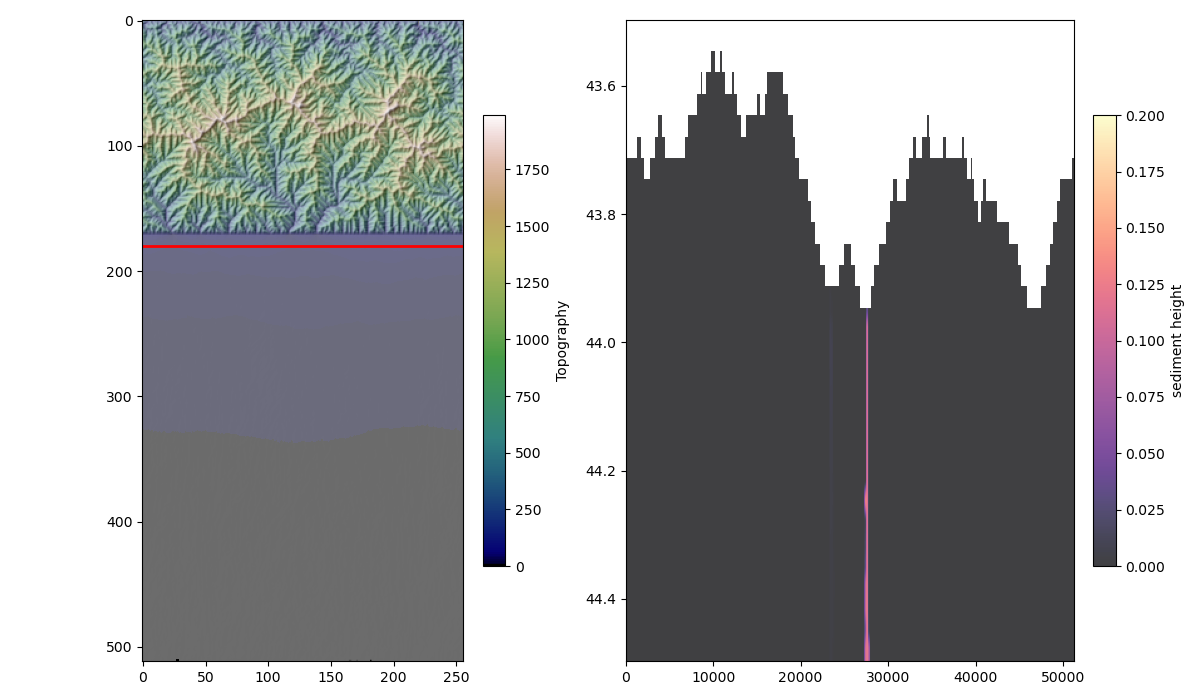

In [8]:
fig,ax = plt.subplots(1,2, figsize = (12,7))

topo = ts.get_topo().reshape(rshp)


row = 180
n_cell_in_depth = 30


ax[1].set_facecolor("white")
ax[1].invert_yaxis()


transec = np.flip(np.rot90(ts.get_transect_TSP(row,n_cell_in_depth,True).reshape(nx,n_cell_in_depth)))
transec[transec < 0] = np.nan

im = ax[1].imshow(transec, cmap ="magma", alpha = 0.75,vmin = 0, vmax = 0.2,
                  extent = [0,nx*dx,topo[row,:].max(),topo[row,:].max() - nz], aspect = 'auto')# 




top = ax[0].imshow(ts.get_topo().reshape(rshp), cmap = 'gist_earth', vmin =0)
tophs = ax[0].imshow(ts.connector.get_HS(ts.get_topo()).reshape(rshp), cmap = 'gray', vmin =0, vmax = 1, alpha = 0.6)
ax[0].axhline(row, color = 'r', lw = 2)

plt.colorbar(im, label = "sediment height",fraction=0.046, pad=0.04)
plt.colorbar(top, label = "Topography",fraction=0.046, pad=0.04)
plt.tight_layout()